In [1]:
import os
import cv2 
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,confusion_matrix

PART 1 

In [2]:
def PCA_Gray(Data,dim = 3):
    means = []

    for img in Data:
        means.append(img.mean())

    image_Arr = np.array(Data)
    means_Arr = np.array(means).reshape(1,len(Data))

    normalized_img = np.subtract(image_Arr.T , means_Arr)

    covariance_m = np.matmul(normalized_img.T,normalized_img)

    val,vec = np.linalg.eig(covariance_m)

    index = val.argsort()

    selected_vecs = []

    for j in range(len(index)-1,len(index)-dim-1,-1):
        selected_vecs.append(vec[index[j]])

    selected_vecs = np.array(selected_vecs)

    projection = np.matmul(normalized_img,selected_vecs.T)
    
    features = []
    for img in image_Arr:
        img = img.reshape(1,img.shape[0])
        img = np.matmul(img,projection).flatten()
        features.append(img)
    


    return np.array(features) 
    

In [3]:
img_arr = []

# Reading images from directory
for img in os.listdir("Dataset1"):
    image = cv2.imread("Dataset1/"+img,0)
    image = cv2.resize(image,(256,256)).flatten()
    image = image / 255
    img_arr.append(image)



features = PCA_Gray(img_arr)
print(features)
# Scaling PCA features between 0 and 1
Scaler = MinMaxScaler()
features = Scaler.fit_transform(features)



[[ 4646.82047877 -7124.49454716  6909.51077325]
 [ 3188.79254663 -7273.80878829  5670.77523155]
 [ 3413.0395549  -7260.53345758  6082.2726813 ]
 [ 4170.07484673 -7293.94129825  6702.46066443]
 [ 5744.87974473 -7498.93190129  7556.35606088]
 [ 5367.98140451 -8684.68967281  8058.0512543 ]
 [ 5136.98065231 -8301.25671094  7333.72094264]
 [ 5951.74733162 -8404.71680898  7120.68467186]
 [ 3001.53197583 -6945.47166426  6974.37708458]
 [ 4750.03016036 -8030.64110849  7772.26315692]
 [ 4717.29874626 -7704.1949331   7548.53936813]]


In [186]:
img_names = [i for i in os.listdir("Dataset1")]

col_names = [("PC " + str(i+1)) for i in range(len(features[0]))]


df = pd.DataFrame(features,index=img_names,columns=col_names)

df

,PC 1,PC 2,PC 3
Aligned_Fighter01.bmp,0.557684,0.897067,0.518891
Aligned_Fighter02.bmp,0.063474,0.811216,0.000000
Aligned_Fighter03.bmp,0.139484,0.818849,0.172371
Aligned_Fighter04.bmp,0.396087,0.799640,0.432160
Aligned_Fighter05.bmp,0.929881,0.681776,0.789846
Aligned_Fighter06.bmp,0.802128,0.000000,1.000000
Aligned_Fighter07.bmp,0.723828,0.220463,0.696587
Aligned_Fighter08.bmp,1.000000,0.160976,0.607349
Aligned_Fighter09.bmp,0.000000,1.000000,0.546062
Aligned_Fighter10.bmp,0.592668,0.376059,0.880287


PART 2 
    

PREPARING DATA

In [187]:
train_img = []
train_labels = []
train_dict = {}


for foldername in os.listdir("Dataset2")[:-1]: 
    
    train_labels.append(foldername)
    for filename in os.listdir("Dataset2/"+foldername):
        
        Path = "Dataset2/" + foldername +"/"+filename
        img = cv2.imread(Path,1)
        img = cv2.resize(img,(200,200))
        
                 
        train_img.append(img)
   



for i in range(len(train_labels)):
    train_dict[i] = train_labels[i]

print(train_dict)

{0: 'airplane', 1: 'bear', 2: 'blimp', 3: 'bonsai', 4: 'cactus', 5: 'dog', 6: 'goat', 7: 'goose', 8: 'ibis', 9: 'iris'}


In [188]:
query_img = []
query_labels = []
query_dict = {}
Path = "Dataset2/QUERY_IMAGES"
for filename in os.listdir(Path):
    img = cv2.imread(Path+"/"+filename,1)
    img = cv2.resize(img,(200,200))
    
    query_img.append(img)
    query_labels.append(filename.split("_")[0])


for i in range(len(query_labels)):
    query_dict[i] = query_labels[i]

Implementing Necessary Functions

In [189]:
def PCA_RGB(Data,dim = 3):
    
    # Storing each channel's values
    Red = []
    Green = []
    Blue = []
  
    for img in Data:
        
        for channel in range(3):
            channel_data = img[:,:,channel].flatten()
            if(channel == 0):
                Blue.append(channel_data)
            elif(channel ==1):
                Green.append(channel_data)
            else:
                Red.append(channel_data)

    # Converting each channel to their PCA components
    features_Red = PCA_Gray(Red)
    features_Green = PCA_Gray(Green)
    features_Blue = PCA_Gray(Blue)

    Scaler = MinMaxScaler()
    
    features_Red = Scaler.fit_transform(features_Red)
    features_Green = Scaler.fit_transform(features_Green)
    features_Blue = Scaler.fit_transform(features_Blue)

    # Concatenating pca features
    features = np.array(list(zip(features_Red,features_Green,features_Blue))) # (300,3,3)

    features = features.reshape(features.shape[0],9)  # (300,9)

    return features

In [190]:
def euclidean(x1,x2):
    sum_of_squares = 0

    for i in range(len(x1)):
        
        diff = x1[i] - x2[i]
        
        sum_of_squares += diff**2
    
    return sum_of_squares ** 0.5

In [191]:
def histogram_RGB(image):
    hist = []
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    for channel in range(2,-1,-1):
        histogram = np.zeros(256)
        for pixel in range(256):
            histogram[pixel] = np.count_nonzero(image[:,:,channel] == pixel)
            
        hist.append(histogram)

    return np.array(hist)

In [192]:
def histogram_HSV(image):
    hist = []
    image = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)

    for channel in range(2,-1,-1):
        histogram = np.zeros(256)
        for pixel in range(256):
            histogram[pixel] = np.count_nonzero(image[:,:,channel] == pixel)
            
        hist.append(histogram)

    return np.array(hist)

In [193]:
def Show_Ten_Nearest(train,test,query_dict,train_dict,query_len = 20, train_len = 300):
    # For each query image, distance between each train image is calculated and stored in distances list. Then distances list is sorted and 10 nearest image is shown.
    for i in range(query_len):  
        distances = [] 
        for j in range(train_len):
        
            label = train_dict[ j // 30 ]  
            distance = euclidean(test[i],train[j]) 
        
            distances.append((distance,label)) 
    
        distances.sort()

        ranked_list = distances[:10]
        print(f"10 Nearest label for: {query_dict[i]}\n")
        for k in ranked_list:
            print(f"Distance: {k[0]} , Class: {k[1]}")
        print("\n*******************************************\n")

In [194]:
def calculateMAP(train,test,query_labels,train_dict,query_len = 20,train_len = 300):
    precisions = [[] for i in range(query_len)] # Empty lists for each query class (2 for each)


    for i in range(query_len):  # Looping through query images
        distances = [] # Distance list for each query image
        for j in range(train_len): # Inner loop for train images
            label = train_dict[ j // 30 ]  # Label of train image
            distance = euclidean(test[i],train[j]) 
            
            distances.append((distance,label)) # Distances are stored with their labels.
        
        distances.sort()


        # Precision calculations for each query image


        k = 0   # Retrieved images
        found = 0 # Relevant images
        
        while(found<30): # Since there are 30 relevant image for each class, loop ends at when found = 30
            nearest_img_label = distances[k][1] # Image at the K. rank
            
            if(nearest_img_label == query_labels[i]): # If image is relevant
            
                found+=1
                precision = found / (k+1) 
                
                precisions[i].append(precision)
            k+=1


    # Taking mean of each precision list
    for i in range(len(precisions)):
        precisions[i] = np.array(precisions[i]).mean() 



    # MAP calculation for each class
    MAP_scores = []
    for i in range(0,len(precisions),2): 
        MAP = (precisions[i] + precisions[i+1]) / 2
        MAP_scores.append(MAP)



    for i in range(len(MAP_scores)):
        print(f"MAP Score: {MAP_scores[i]},\tLabel: {train_dict[i]}")

In [195]:
def K_means(train,num_clusters = 10):
    scaler = StandardScaler()
    k_features = scaler.fit_transform(train)
   

    kmeans = KMeans(num_clusters)
    x=kmeans.fit_predict(k_features)


    score = silhouette_score(train,kmeans.labels_)
    print(f"Silhoutte Score of Model: {score}")

2.1) PCA Features

In [196]:
features_train = PCA_RGB(train_img) # Shape:(300,9)
features_query = PCA_RGB(query_img) # Shape:(20,9)


In [197]:
# Showing 10 nearest image for each query image.
Show_Ten_Nearest(features_train,features_query,query_dict,train_dict)

10 Nearest label for: airplane

Distance: 0.6825893575353108 , Class: goat
Distance: 0.6871881223541826 , Class: blimp
Distance: 0.7018319928686003 , Class: goose
Distance: 0.7030201902837425 , Class: dog
Distance: 0.706336583592339 , Class: cactus
Distance: 0.7153540079495164 , Class: ibis
Distance: 0.7228264088893767 , Class: goat
Distance: 0.72344075446364 , Class: dog
Distance: 0.7237783463543439 , Class: goat
Distance: 0.7261327066445619 , Class: cactus

*******************************************

10 Nearest label for: airplane

Distance: 0.6697058477906115 , Class: iris
Distance: 0.7058927993497028 , Class: ibis
Distance: 0.722811264625896 , Class: goose
Distance: 0.7311906407192221 , Class: bear
Distance: 0.7347363408493623 , Class: iris
Distance: 0.7388333116806878 , Class: cactus
Distance: 0.7498133977445536 , Class: iris
Distance: 0.7535379859989524 , Class: goat
Distance: 0.7547717104612599 , Class: ibis
Distance: 0.7607267438752447 , Class: iris

**************************

In [198]:
# MAP Calculation using PCA features
calculateMAP(features_train,features_query,query_labels,train_dict)

MAP Score: 0.08488143030228779,	Label: airplane
MAP Score: 0.17694627764823895,	Label: bear
MAP Score: 0.08875383110013893,	Label: blimp
MAP Score: 0.0761899117789809,	Label: bonsai
MAP Score: 0.13746473967986766,	Label: cactus
MAP Score: 0.11634245724154468,	Label: dog
MAP Score: 0.10411679761722493,	Label: goat
MAP Score: 0.11455972845130069,	Label: goose
MAP Score: 0.18825510772944387,	Label: ibis
MAP Score: 0.12514202755287124,	Label: iris


In [199]:
# K-Means for PCA features
K_means(features_train)

Silhoutte Score of Model: 0.16410580806396524


c:\Users\burak\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\burak\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


2.2) Color Histogram Features

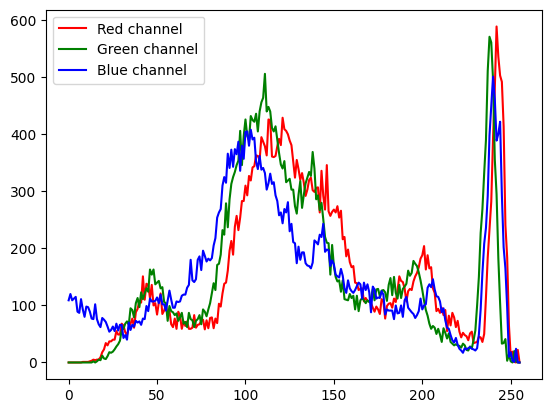

In [200]:
# Testing for single image (RGB)

test_img = train_img[0]

image = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)

hist = histogram_RGB(image)

plt.plot(hist[0],color="red",label="Red channel")
plt.plot(hist[1],color = "green",label = "Green channel")
plt.plot(hist[2],color="blue",label="Blue channel")
plt.legend()

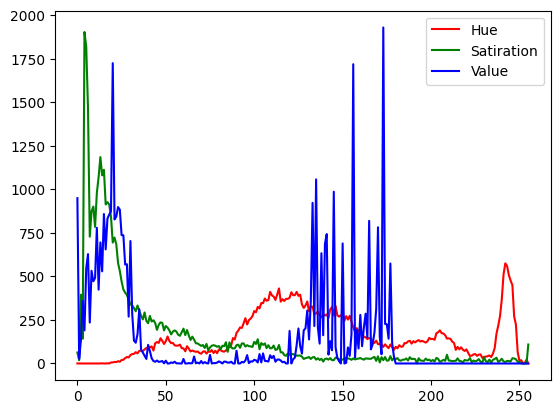

In [201]:
# Testing for single image (HSV)

test_img = train_img[0]


hist = histogram_HSV(test_img)

plt.plot(hist[0],color="red",label="Hue")
plt.plot(hist[1],color = "green",label="Satiration")
plt.plot(hist[2],color="blue",label="Value")
plt.legend()

In [202]:
train_hist_RGB = []
query_hist_RGB = []

train_hist_HSV = []
query_hist_HSV = []

for img in train_img:
    train_hist_RGB.append(histogram_RGB(img))
    train_hist_HSV.append(histogram_HSV(img))

for img in query_img:
    query_hist_RGB.append(histogram_RGB(img))
    query_hist_HSV.append(histogram_HSV(img))


# Flattening histogram information
train_hist_RGB = np.array(train_hist_RGB).reshape((300,256*3))
train_hist_HSV = np.array(train_hist_HSV).reshape((300,256*3))


query_hist_RGB = np.array(query_hist_RGB).reshape((20,256*3))
query_hist_HSV = np.array(query_hist_HSV).reshape((20,256*3))



In [203]:
# Showing 10 nearest image for each query image. (RGB)

Show_Ten_Nearest(train_hist_RGB,query_hist_RGB,query_dict,train_dict)



10 Nearest label for: airplane

Distance: 6168.018482462581 , Class: airplane
Distance: 6347.151802186552 , Class: airplane
Distance: 6370.326993177038 , Class: airplane
Distance: 6750.367693688989 , Class: airplane
Distance: 6825.253987947995 , Class: airplane
Distance: 7043.282473392644 , Class: bonsai
Distance: 7052.370098059233 , Class: airplane
Distance: 7234.52693684943 , Class: airplane
Distance: 7378.9252604969515 , Class: bonsai
Distance: 7421.8098870828 , Class: airplane

*******************************************

10 Nearest label for: airplane

Distance: 0.0 , Class: airplane
Distance: 4032.8744091528565 , Class: airplane
Distance: 4077.5448495387514 , Class: dog
Distance: 4308.402720266526 , Class: airplane
Distance: 4486.25166480883 , Class: goat
Distance: 4555.769967853952 , Class: ibis
Distance: 4862.24701141355 , Class: goat
Distance: 4948.9117995777615 , Class: goat
Distance: 5129.814616533428 , Class: cactus
Distance: 5143.702168671899 , Class: cactus

*************

In [204]:
# Showing 10 nearest image for each query image. (HSV)

Show_Ten_Nearest(train_hist_HSV,query_hist_HSV,query_dict,train_dict)

10 Nearest label for: airplane

Distance: 9111.31691908475 , Class: airplane
Distance: 10166.001278772299 , Class: bonsai
Distance: 10523.946978201668 , Class: airplane
Distance: 11137.94460392042 , Class: airplane
Distance: 11161.829330356202 , Class: dog
Distance: 11360.168748746648 , Class: airplane
Distance: 11446.540525416402 , Class: airplane
Distance: 11484.578790708869 , Class: airplane
Distance: 11589.024635403965 , Class: airplane
Distance: 11771.030116349206 , Class: bear

*******************************************

10 Nearest label for: airplane

Distance: 0.0 , Class: airplane
Distance: 4646.380957261254 , Class: airplane
Distance: 5470.2327189983425 , Class: airplane
Distance: 5526.4551025046785 , Class: bear
Distance: 5852.965060548371 , Class: goat
Distance: 6113.229261200662 , Class: cactus
Distance: 6191.564099643966 , Class: bear
Distance: 6259.077088517124 , Class: cactus
Distance: 6262.600578034655 , Class: dog
Distance: 6287.184425480137 , Class: cactus

********

In [205]:
# MAP score for histogram features (RGB)
calculateMAP(train_hist_RGB,query_hist_RGB,query_labels,train_dict)

MAP Score: 0.2834970450008402,	Label: airplane
MAP Score: 0.12255315714902927,	Label: bear
MAP Score: 0.06501062666051942,	Label: blimp
MAP Score: 0.12714023554971057,	Label: bonsai
MAP Score: 0.15856092540161437,	Label: cactus
MAP Score: 0.1255122581953717,	Label: dog
MAP Score: 0.16517878324230167,	Label: goat
MAP Score: 0.14859738087950802,	Label: goose
MAP Score: 0.09940243122706208,	Label: ibis
MAP Score: 0.20674810110090924,	Label: iris


In [206]:
# MAP score for histogram features (HSV)
calculateMAP(train_hist_HSV,query_hist_HSV,query_labels,train_dict)

MAP Score: 0.28049610401409986,	Label: airplane
MAP Score: 0.15992803646007112,	Label: bear
MAP Score: 0.06452922992898984,	Label: blimp
MAP Score: 0.1029766920175263,	Label: bonsai
MAP Score: 0.12358279646289294,	Label: cactus
MAP Score: 0.10450056903783192,	Label: dog
MAP Score: 0.17251119220287076,	Label: goat
MAP Score: 0.15597045704762125,	Label: goose
MAP Score: 0.1020558323607928,	Label: ibis
MAP Score: 0.19145696071746976,	Label: iris


In [207]:
# K-Means for histogram features (RGB)
K_means(train_hist_RGB)


Silhoutte Score of Model: -0.02266565859258094


c:\Users\burak\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\burak\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [208]:
# K-Means for histogram features (HSV)
K_means(train_hist_HSV)

Silhoutte Score of Model: -0.11054149474215214

c:\Users\burak\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\burak\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


PART 3) LOGISTIC REGRESSION

In [209]:
class LogisticRegression: # Logistic Regression for two classes.
    def __init__(self,learning_Rate,iterations):
        self.lr = learning_Rate
        self.weights = 0
        self.bias = 0
        self.iterations  = iterations # Number of iterations for gradient descent algorithm
    
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))



    def fit(self,train_x,train_y):
        sample_num = train_x.shape[0]
        sample_features = train_x.shape[1]

        # Setting initial weights and biases as 0
        self.weights = np.zeros(sample_features)  
        self.bias = 0

        for i in range(self.iterations):
            result = np.dot(train_x,self.weights) + self.bias  # Calculating (WX + B)
            prediction = self.sigmoid(result) 

            # Gradients
            dw = (1/sample_num) * np.dot(train_x.T , (prediction - train_y))
            db = (1/sample_num) * np.sum(prediction - train_y)

            # Weight and bias update
            self.weights = self.weights - self.lr * dw
            self.bias = self.bias - self.lr * db

    
    def predict(self,test_x):
        result = np.dot(test_x,self.weights) + self.bias
        prediction = self.sigmoid(result)
        for i in range(len(prediction)):
            if prediction[i] > 0.5:
                prediction[i] = 1
            else:
                prediction[i] = 0
    
        return prediction
    
        

In [210]:
class LogisticRegressionOVA: # Logistic Regression with 10 classes (One v All)
    def __init__(self,learning_Rate,iterations,class_num = 10):
        self.lr = learning_Rate
        self.iterations  = iterations
        self.models = 0
        self.class_num = class_num
    

    def fit(self,train_x,train_y):
        sample_num = train_x.shape[0]
        sample_features = train_x.shape[1]

        self.models = []  

        # One model is trained for each class.
        # For each instance, if that instance belongs to class that we train, it gets 1 in train_Y list, otherwise 0.
        # train_Y is desired_class variable in this function.
        
        for i in range(self.class_num): 
            
            desired_class = []
            for j in train_y:
                if j == i:
                    desired_class.append(1)
                else:
                    desired_class.append(0)
            desired_class = np.array(desired_class)

            model = LogisticRegression(self.lr,self.iterations)
            model.fit(train_x,desired_class)
            self.models.append(model)
    


    
    def predict(self,test_x):
        prediction = np.zeros((test_x.shape[0],len(self.models)))

        for i,model in enumerate(self.models):
            prediction[:,i] = model.predict(test_x)
        return np.argmax(prediction,axis=1)

3.1) Binary Classification

In [212]:
train_X_binary = np.array(train_img[:60])/255
train_X_binary = train_X_binary.reshape(60,120000)

train_Y_binary = []
for i in range(2):
    train_Y_binary.append(np.ones(30) * i)

train_Y_binary = np.array(train_Y_binary).flatten()

test_X_binary = np.array(query_img[:4])/255
test_X_binary = np.array(test_X_binary).reshape(4,120000)
test_Y_binary = []
for i in range(2):
    test_Y_binary.append(np.ones(2) * i)
test_Y_binary = np.array(test_Y_binary).flatten()

In [213]:
Lr_Binary = LogisticRegression(learning_Rate=0.001,iterations=1000)
Lr_Binary.fit(train_X_binary,train_Y_binary)


In [224]:
prediction = Lr_Binary.predict(test_X_binary)
print("Truth\tPrediction")
for i in range(len(prediction)):
    print(str(int(test_Y_binary[i]))+"\t"+str(int(prediction[i])))
    

Truth	Prediction
0	0
0	0
1	1
1	1


In [225]:
m =confusion_matrix(test_Y_binary,prediction)
m

array([[2, 0],
       [0, 2]], dtype=int64)

3.2) 10-Class Classification

In [217]:
train_X = np.array(train_img)/255
train_X = train_X.reshape(300,120000)

train_Y = []
for i in range(10):
    train_Y.append(np.ones(30) * i)

train_Y = np.array(train_Y).flatten()

In [218]:
Lr = LogisticRegressionOVA(learning_Rate= 0.001,iterations=1000)
Lr.fit(train_X,train_Y)

In [221]:
test_X = np.array(query_img)/255  
test_X = test_X.reshape(20,120000)

test_Y = []
for i in range(10):
    test_Y.append(np.ones(2) * i)
test_Y = np.array(test_Y).flatten()


prediction = Lr.predict(test_X)

print("Truth\tPrediction")
for i in range(len(prediction)):
    if(test_Y[i] == prediction[i]):
        print(str(int(test_Y[i]))+"\t"+str(prediction[i]) + "\tMatch")
    else:

        print(str(int(test_Y[i]))+"\t"+str(prediction[i]))


Truth	Prediction
0	0	Match
0	0	Match
1	0
1	0
2	2	Match
2	0
3	6
3	8
4	0
4	0
5	0
5	0
6	9
6	2
7	0
7	9
8	9
8	6
9	9	Match
9	0


In [220]:
confusion_matrix(test_Y,prediction)

array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int64)